### Necessary Imports

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import itertools
import sys
import random
import matplotlib.pyplot as plt

### Loading in Datasets and Preparing Dataframes for Training

In [3]:
##Load in dynamic features for a single song

features_path = 'DEAM DATASET/FEATURES/2.csv'
df = pd.read_csv(features_path, sep=";")
df_small = df.iloc[:, :4]
df_small.head()
print(df_small.shape)
df_small.head()



(449, 4)


,frameTime,F0final_sma_stddev,F0final_sma_amean,voicingFinalUnclipped_sma_stddev
0,0.0,0.00000,0.00000,0.000000
1,0.5,46.61850,41.97005,0.378904
2,1.0,26.41163,83.31398,0.132493
3,1.5,20.73190,94.65977,0.020989
4,2.0,11.78187,104.48090,0.017434


In [4]:
arousal_path = 'DEAM DATASET/ANNOTATIONS/annotations per song/dynamic/arousal.csv'
arousal_df = pd.read_csv(arousal_path, sep=",")
print("Wide format shape:", arousal_df.shape)

Wide format shape: (1802, 1225)


In [5]:
# Convert from wide to long format, but call the melted column something temporary
arousal_long = arousal_df.melt(
    id_vars=['song_id'],       # Keep 'song_id' as is
    var_name='temp_timestamp', # Temporary column name for the old headers
    value_name='arousal_value'
)

# Parse the numeric time from 'temp_timestamp' and store it in 'time_s'
arousal_long['time_s'] = (
    arousal_long['temp_timestamp']
    .str.replace('sample_', '', regex=False)
    .str.replace('ms', '', regex=False)
    .astype(float) / 1000.0
)

# Drop rows that have no arousal_value
arousal_long.dropna(subset=['arousal_value'], inplace=True)

# Reorder columns so that time_s appears right after song_id
arousal_long = arousal_long[['song_id', 'time_s', 'arousal_value']]

# Sort by song_id and time_s
arousal_long.sort_values(by=['song_id', 'time_s'], inplace=True)
arousal_long.reset_index(drop=True, inplace=True)

print("Long format shape:", arousal_long.shape)
arousal_long.head(10)

Long format shape: (129999, 3)


,song_id,time_s,arousal_value
0,2,15.0,-0.109386
1,2,15.5,-0.114942
2,2,16.0,-0.116413
3,2,16.5,-0.118613
4,2,17.0,-0.126457
5,2,17.5,-0.133199
6,2,18.0,-0.136855
7,2,18.5,-0.144713
8,2,19.0,-0.138985
9,2,19.5,-0.137602


In [6]:
valence_path = 'DEAM DATASET/ANNOTATIONS/annotations per song/dynamic/valence.csv'
valence_df = pd.read_csv(valence_path, sep=",")
print("Wide format shape:", valence_df.shape)

Wide format shape: (1802, 1224)


In [7]:
# Convert from wide to long format, but call the melted column something temporary
valence_long = valence_df.melt(
    id_vars=['song_id'],       # Keep 'song_id' as is
    var_name='temp_timestamp', # Temporary column name for the old headers
    value_name='valence_value'
)

# Parse the numeric time from 'temp_timestamp' and store it in 'time_s'
valence_long['time_s'] = (
    valence_long['temp_timestamp']
    .str.replace('sample_', '', regex=False)
    .str.replace('ms', '', regex=False)
    .astype(float) / 1000.0
)

# Drop rows that have no valence_value
valence_long.dropna(subset=['valence_value'], inplace=True)

# Reorder columns so that time_s appears right after song_id
valence_long = valence_long[['song_id', 'time_s', 'valence_value']]

# Sort by song_id and time_s
valence_long.sort_values(by=['song_id', 'time_s'], inplace=True)
valence_long.reset_index(drop=True, inplace=True)

print("Long format shape:", valence_long.shape)
valence_long.head(10)


Long format shape: (129998, 3)


,song_id,time_s,valence_value
0,2,15.0,-0.073341
1,2,15.5,-0.074661
2,2,16.0,-0.074077
3,2,16.5,-0.078154
4,2,17.0,-0.081588
5,2,17.5,-0.080873
6,2,18.0,-0.083611
7,2,18.5,-0.082145
8,2,19.0,-0.081632
9,2,19.5,-0.083874


In [8]:
# 1) Extract the unique (song_id, time_s) pairs from each DataFrame
arousal_keys = arousal_long[['song_id', 'time_s']].drop_duplicates()
valence_keys = valence_long[['song_id', 'time_s']].drop_duplicates()

# 2) Find the intersection of those keys via an inner merge
common_keys = pd.merge(
    arousal_keys, 
    valence_keys, 
    how='inner', 
    on=['song_id', 'time_s']
)

# 3) Filter both DataFrames to keep only the common rows
arousal_long_filtered = pd.merge(
    arousal_long, 
    common_keys, 
    how='inner', 
    on=['song_id', 'time_s']
)

valence_long_filtered = pd.merge(
    valence_long, 
    common_keys, 
    how='inner', 
    on=['song_id', 'time_s']
)

# 4) Now both arousal_long_filtered and valence_long_filtered 
#    have only the rows whose (song_id, time_s) appear in both original DFs.
print("Arousal before:", arousal_long.shape)
print("Arousal after :", arousal_long_filtered.shape)
print("Valence before:", valence_long.shape)
print("Valence after :", valence_long_filtered.shape)

Arousal before: (129999, 3)
Arousal after : (129995, 3)
Valence before: (129998, 3)
Valence after : (129995, 3)


In [9]:
# We'll create an empty list to hold merged data for each song
merged_list = []

# Group the valence_long DataFrame by song_id
for song, group_df in valence_long.groupby('song_id'):
    # Construct the path for the features CSV corresponding to this song.
    features_path = f"DEAM DATASET/FEATURES/{song}.csv"
    
    # Load the features CSV
    df_feat = pd.read_csv(features_path, sep=";")
    
    # Ensure 'frameTime' is numeric
    df_feat['frameTime'] = df_feat['frameTime'].astype(float)
    
    # Make a copy of group_df, create a 'time_round' column
    group_df = group_df.copy()
    group_df['time_round'] = group_df['time_s'].round(1)
    df_feat['time_round'] = df_feat['frameTime'].round(1)
    
    # Merge on 'time_round'
    merged_df = pd.merge(
        group_df, 
        df_feat, 
        on='time_round', 
        how='inner'
    )
    
    # Drop the columns we don't want
    # e.g. 'valence_value' plus the 'time_round' used for merging
    merged_df = merged_df.drop(columns=['valence_value', 'time_round'])
    
    # Reorder columns so that 'frameTime' appears right after 'time_s'
    # 1) Keep 'song_id', 'time_s', 'frameTime' in front
    # 2) Then all remaining columns
    desired_order = (
        ["song_id", "time_s", "frameTime"] +
        [col for col in merged_df.columns 
         if col not in ["song_id","time_s","frameTime"]]
    )
    merged_df = merged_df[desired_order]
    
    merged_list.append(merged_df)

# Concatenate all merged DataFrames
features_long = pd.concat(merged_list, ignore_index=True)

# Sort by song_id and time_s for clarity
features_long = features_long.sort_values(by=['song_id','time_s']).reset_index(drop=True)

print("Final features_long shape:", features_long.shape)
features_long.head(20)


Final features_long shape: (127837, 263)


,song_id,time_s,frameTime,F0final_sma_stddev,F0final_sma_amean,voicingFinalUnclipped_sma_stddev,voicingFinalUnclipped_sma_amean,jitterLocal_sma_stddev,jitterLocal_sma_amean,jitterDDP_sma_stddev,...,pcm_fftMag_mfcc_sma_de[10]_stddev,pcm_fftMag_mfcc_sma_de[10]_amean,pcm_fftMag_mfcc_sma_de[11]_stddev,pcm_fftMag_mfcc_sma_de[11]_amean,pcm_fftMag_mfcc_sma_de[12]_stddev,pcm_fftMag_mfcc_sma_de[12]_amean,pcm_fftMag_mfcc_sma_de[13]_stddev,pcm_fftMag_mfcc_sma_de[13]_amean,pcm_fftMag_mfcc_sma_de[14]_stddev,pcm_fftMag_mfcc_sma_de[14]_amean
0,2,15.0,15.0,12.179310,101.63020,0.028607,0.759366,0.153100,0.141526,0.082871,...,2.113171,-0.045443,2.246814,-0.175230,2.488252,-0.177010,1.845097,0.062042,2.156926,0.070399
1,2,15.5,15.5,9.061675,108.40070,0.023301,0.782306,0.125588,0.054276,0.072678,...,2.080907,0.001877,2.480643,0.232135,2.331740,-0.158096,2.049178,0.016943,1.694531,0.036801
2,2,16.0,16.0,2.424723,111.31840,0.025118,0.791416,0.024865,0.023444,0.035991,...,2.344492,-0.095686,2.984664,0.216907,2.957226,0.028751,2.177865,-0.120895,1.762214,0.030089
3,2,16.5,16.5,10.090170,108.11900,0.024484,0.790459,0.111933,0.068022,0.140163,...,2.685361,-0.134019,2.430664,-0.125082,2.765290,-0.113778,2.214839,0.109757,1.669868,-0.088037
4,2,17.0,17.0,9.906472,106.04090,0.022463,0.785395,0.110868,0.068772,0.139967,...,2.256249,-0.148475,1.796319,-0.251045,1.981488,-0.064730,2.544847,0.110850,1.621264,0.013263
5,2,17.5,17.5,12.793330,99.37373,0.035582,0.772333,0.110345,0.085234,0.072208,...,2.207992,-0.078466,2.174250,-0.057569,1.699886,0.212710,2.531387,-0.020731,1.972716,0.075636
6,2,18.0,18.0,23.774270,92.12128,0.030878,0.756733,0.169420,0.157795,0.183317,...,2.385549,-0.037239,2.347607,0.100225,2.136324,0.313819,2.021433,-0.138854,2.332479,-0.020943
7,2,18.5,18.5,23.834850,101.84150,0.018084,0.761258,0.157075,0.117312,0.177374,...,2.599840,-0.139683,2.029154,0.127472,2.177028,-0.038570,1.946708,-0.064710,2.156453,-0.106750
8,2,19.0,19.0,23.660830,98.42744,0.020074,0.755509,0.066021,0.064578,0.070553,...,2.252914,0.186055,1.872028,-0.048866,1.955725,-0.271147,1.958746,0.033960,1.719860,0.075808
9,2,19.5,19.5,21.124950,91.64322,0.023839,0.751603,0.205253,0.123945,0.211324,...,1.538709,0.219759,1.921245,-0.094457,2.018209,-0.011243,1.685612,-0.055171,1.505774,0.098570


In [10]:
features_long.head(127837)

,song_id,time_s,frameTime,F0final_sma_stddev,F0final_sma_amean,voicingFinalUnclipped_sma_stddev,voicingFinalUnclipped_sma_amean,jitterLocal_sma_stddev,jitterLocal_sma_amean,jitterDDP_sma_stddev,...,pcm_fftMag_mfcc_sma_de[10]_stddev,pcm_fftMag_mfcc_sma_de[10]_amean,pcm_fftMag_mfcc_sma_de[11]_stddev,pcm_fftMag_mfcc_sma_de[11]_amean,pcm_fftMag_mfcc_sma_de[12]_stddev,pcm_fftMag_mfcc_sma_de[12]_amean,pcm_fftMag_mfcc_sma_de[13]_stddev,pcm_fftMag_mfcc_sma_de[13]_amean,pcm_fftMag_mfcc_sma_de[14]_stddev,pcm_fftMag_mfcc_sma_de[14]_amean
0,2,15.0,15.0,12.179310,101.63020,0.028607,0.759366,0.153100,0.141526,0.082871,...,2.113171,-0.045443,2.246814,-0.175230,2.488252,-0.177010,1.845097,0.062042,2.156926,0.070399
1,2,15.5,15.5,9.061675,108.40070,0.023301,0.782306,0.125588,0.054276,0.072678,...,2.080907,0.001877,2.480643,0.232135,2.331740,-0.158096,2.049178,0.016943,1.694531,0.036801
2,2,16.0,16.0,2.424723,111.31840,0.025118,0.791416,0.024865,0.023444,0.035991,...,2.344492,-0.095686,2.984664,0.216907,2.957226,0.028751,2.177865,-0.120895,1.762214,0.030089
3,2,16.5,16.5,10.090170,108.11900,0.024484,0.790459,0.111933,0.068022,0.140163,...,2.685361,-0.134019,2.430664,-0.125082,2.765290,-0.113778,2.214839,0.109757,1.669868,-0.088037
4,2,17.0,17.0,9.906472,106.04090,0.022463,0.785395,0.110868,0.068772,0.139967,...,2.256249,-0.148475,1.796319,-0.251045,1.981488,-0.064730,2.544847,0.110850,1.621264,0.013263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127832,2058,271.0,271.0,0.027195,82.27454,0.003714,0.830707,0.003523,0.005365,0.003196,...,1.204244,-0.125617,0.974096,-0.152836,0.774953,-0.018452,0.970936,0.060483,0.612108,0.091543
127833,2058,271.5,271.5,0.026435,82.30186,0.000971,0.832696,0.002279,0.002994,0.001759,...,1.147311,0.030107,0.837046,0.028209,0.814183,-0.060477,0.921027,0.002741,0.442673,-0.017267
127834,2058,272.0,272.0,0.023522,82.31603,0.001139,0.832699,0.001343,0.001471,0.001229,...,1.178659,0.065469,0.955342,-0.152497,0.746926,0.040692,0.757597,-0.038592,0.506054,0.054767
127835,2058,272.5,272.5,0.027330,82.31680,0.001310,0.832537,0.001575,0.001696,0.000846,...,1.231314,-0.059246,1.106586,-0.064512,0.668658,-0.015995,0.799668,-0.022004,0.539285,-0.002860


In [11]:
import pandas as pd

# 1) Extract unique (song_id, time_s) from each DataFrame
val_keys  = valence_long[['song_id','time_s']].drop_duplicates()
aro_keys  = arousal_long[['song_id','time_s']].drop_duplicates()
feat_keys = features_long[['song_id','time_s']].drop_duplicates()

# 2) Find the intersection among all three
#    a) Intersection of val_keys & aro_keys
common_keys = pd.merge(val_keys, aro_keys, how='inner', on=['song_id','time_s'])
#    b) Then intersect that with feat_keys
common_keys = pd.merge(common_keys, feat_keys, how='inner', on=['song_id','time_s'])

# Now common_keys has all (song_id, time_s) that appear in valence_long, arousal_long, and features_long

# 3) Filter each DataFrame to keep only the common rows
valence_long_filtered = pd.merge(valence_long, common_keys, how='inner', on=['song_id','time_s'])
arousal_long_filtered = pd.merge(arousal_long, common_keys, how='inner', on=['song_id','time_s'])
features_long_filtered = pd.merge(features_long, common_keys, how='inner', on=['song_id','time_s'])

# 4) (Optional) Collect removed rows from each DataFrame for inspection.
#    We'll do a left join with an indicator and select the "left_only" rows.
valence_removed = pd.merge(valence_long, common_keys, how='left', on=['song_id','time_s'], indicator=True)
valence_removed = valence_removed[valence_removed['_merge']=='left_only'].drop(columns=['_merge'])

arousal_removed = pd.merge(arousal_long, common_keys, how='left', on=['song_id','time_s'], indicator=True)
arousal_removed = arousal_removed[arousal_removed['_merge']=='left_only'].drop(columns=['_merge'])

features_removed = pd.merge(features_long, common_keys, how='left', on=['song_id','time_s'], indicator=True)
features_removed = features_removed[features_removed['_merge']=='left_only'].drop(columns=['_merge'])

# 5) Print final shapes
print("valence_long:", valence_long.shape, "-> filtered:", valence_long_filtered.shape)
print("arousal_long:", arousal_long.shape, "-> filtered:", arousal_long_filtered.shape)
print("features_long:", features_long.shape, "-> filtered:", features_long_filtered.shape)

print("Removed rows - valence:", valence_removed.shape)
print("Removed rows - arousal:", arousal_removed.shape)
print("Removed rows - features:", features_removed.shape)

# Now valence_long_filtered, arousal_long_filtered, and features_long_filtered
# contain only the (song_id, time_s) rows present in all three original DFs.
# The "removed" dataframes hold any rows that didn't appear in that intersection.


valence_long: (129998, 3) -> filtered: (127837, 3)
arousal_long: (129999, 3) -> filtered: (127837, 3)
features_long: (127837, 263) -> filtered: (127837, 263)
Removed rows - valence: (2161, 3)
Removed rows - arousal: (2162, 3)
Removed rows - features: (0, 263)


In [100]:
import os

In [101]:
# 1) Create the output folder if it doesn't exist
output_folder = "TRAINING DATA"
os.makedirs(output_folder, exist_ok=True)

# 2) Export each filtered DataFrame to CSV (no index column)
valence_long_filtered.to_csv(os.path.join(output_folder, "valence_long_filtered.csv"), index=False)
arousal_long_filtered.to_csv(os.path.join(output_folder, "arousal_long_filtered.csv"), index=False)
features_long_filtered.to_csv(os.path.join(output_folder, "features_long_filtered.csv"), index=False)

print("Filtered DataFrames saved to the 'TRAINING DATA' folder.")

Filtered DataFrames saved to the 'TRAINING DATA' folder.


In [12]:
val_removed_ids = valence_removed['song_id'].unique()
aro_removed_ids = arousal_removed['song_id'].unique()
feat_removed_ids = features_removed['song_id'].unique()

print("Removed in valence_removed:", val_removed_ids)
print("Removed in arousal_removed:", aro_removed_ids)
print("Removed in features_removed:", feat_removed_ids)


Removed in valence_removed: [1001 1002 1003 ... 2056 2057 2058]
Removed in arousal_removed: [1001 1002 1003 ... 2056 2057 2058]
Removed in features_removed: []


## Testing Data with NN Libraries

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [26]:
# ----- MERGE DATAFRAMES -----
# Merge features_long_filtered and arousal_long_filtered on ['song_id', 'time_s']
data_temp = pd.merge(features_long_filtered, arousal_long_filtered[['song_id', 'time_s', 'arousal_value']], 
                     on=['song_id', 'time_s'], how='inner')

# Merge the result with valence_long_filtered on ['song_id', 'time_s']
data = pd.merge(data_temp, valence_long_filtered[['song_id', 'time_s', 'valence_value']],
                on=['song_id', 'time_s'], how='inner')

#Extract the metadata: (song_id, time_s)
meta = data[['song_id', 'time_s']].values

# Check the merged DataFrame shape and head (for debugging)
print("Merged data shape:", data.shape)
print(data.head())


Merged data shape: (127837, 265)
   song_id  time_s  frameTime  F0final_sma_stddev  F0final_sma_amean  \
0        2    15.0       15.0           12.179310           101.6302   
1        2    15.5       15.5            9.061675           108.4007   
2        2    16.0       16.0            2.424723           111.3184   
3        2    16.5       16.5           10.090170           108.1190   
4        2    17.0       17.0            9.906472           106.0409   

   voicingFinalUnclipped_sma_stddev  voicingFinalUnclipped_sma_amean  \
0                          0.028607                         0.759366   
1                          0.023301                         0.782306   
2                          0.025118                         0.791416   
3                          0.024484                         0.790459   
4                          0.022463                         0.785395   

   jitterLocal_sma_stddev  jitterLocal_sma_amean  jitterDDP_sma_stddev  ...  \
0                0.153

In [27]:
# ----- EXTRACT FEATURES (X) AND TARGETS (y) -----
# Assume columns: 0:"song_id", 1:"time_s", 2:"frameTime", 3:... are the 260 feature columns.
# If that's the case, then:
X = data.iloc[:, 3:3+260].values  # adjust if there are extra columns
y_arousal = data['arousal_value'].values
y_valence = data['valence_value'].values

print("X shape:", X.shape)
print("y_arousal shape:", y_arousal.shape)
print("y_valence shape:", y_valence.shape)

# Optionally, standardize X (for example, using mean=0 and std=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X shape: (127837, 260)
y_arousal shape: (127837,)
y_valence shape: (127837,)


In [28]:
# ----- SPLIT DATA INTO TRAIN AND TEST SETS -----
X_train, X_test, y_arousal_train, y_arousal_test, meta_train, meta_test = train_test_split(
    X_scaled, y_arousal, meta, test_size=0.2, random_state=42
)
_, _, y_valence_train, y_valence_test, _, _ = train_test_split(
    X_scaled, y_valence, meta, test_size=0.2, random_state=42
)

print("Shapes:")
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_arousal_train:", y_arousal_train.shape, "y_arousal_test:", y_arousal_test.shape)
print("meta_train:", meta_train.shape, "meta_test:", meta_test.shape)

Shapes:
X_train: (102269, 260) X_test: (25568, 260)
y_arousal_train: (102269,) y_arousal_test: (25568,)
meta_train: (102269, 2) meta_test: (25568, 2)


In [29]:
# ----- DEFINE A SIMPLE NEURAL NETWORK MODEL -----
def build_model(input_dim):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='linear'))  # regression output
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

# Build model for arousal prediction
arousal_model = build_model(input_dim=X_scaled.shape[1])
print(arousal_model.summary())

# Build model for valence prediction
valence_model = build_model(input_dim=X_scaled.shape[1])
print(valence_model.summary())

/Users/kaskras/Desktop/UNI Y4/F20PA/IMPLEMENTATION/NEURAL NETWORK/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,729 (163.00 KB)

 Trainable params: 41,729 (163.00 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 128)            │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,729 (163.00 KB)

 Trainable params: 41,729 (163.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
# ----- TRAIN THE MODELS -----
# For arousal
arousal_history = arousal_model.fit(X_train, y_arousal_train, epochs=50, batch_size=32,
                                    validation_data=(X_test, y_arousal_test))

# For valence
valence_history = valence_model.fit(X_train, y_valence_train, epochs=50, batch_size=32,
                                    validation_data=(X_test, y_valence_test))


Epoch 1/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 3s 805us/step - loss: 0.3011 - mae: 0.2446 - val_loss: 0.0406 - val_mae: 0.1609
Epoch 2/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step - loss: 0.0487 - mae: 0.1661 - val_loss: 0.0365 - val_mae: 0.1510
Epoch 3/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 2s 760us/step - loss: 0.0415 - mae: 0.1532 - val_loss: 0.0339 - val_mae: 0.1463
Epoch 4/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 2s 738us/step - loss: 0.0349 - mae: 0.1457 - val_loss: 0.0330 - val_mae: 0.1443
Epoch 5/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 2s 740us/step - loss: 0.0324 - mae: 0.1415 - val_loss: 0.0308 - val_mae: 0.1385
Epoch 6/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 3s 781us/step - loss: 0.0310 - mae: 0.1377 - val_loss: 0.0302 - val_mae: 0.1369
Epoch 7/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 2s 734us/step - loss: 0.0294 - mae: 0.1343 - val_loss: 0.0285 - val_mae: 0.1319
Epoch 8/50
3196/3196 ━━━━━━━━━━━━━━━━━━━━ 2s 735us/step - loss: 0.0283 - mae: 0.1315 - val_loss: 0.0281 - val_mae: 0.1316
Epoch 9/50
3196/3196 ━━━

In [31]:
# ----- EVALUATE MODELS -----
arousal_loss, arousal_mae = arousal_model.evaluate(X_test, y_arousal_test)
valence_loss, valence_mae = valence_model.evaluate(X_test, y_valence_test)
print("Arousal - Test Loss (MSE):", arousal_loss, "MAE:", arousal_mae)
print("Valence - Test Loss (MSE):", valence_loss, "MAE:", valence_mae)

799/799 ━━━━━━━━━━━━━━━━━━━━ 0s 440us/step - loss: 0.0215 - mae: 0.1138
799/799 ━━━━━━━━━━━━━━━━━━━━ 0s 400us/step - loss: 0.0224 - mae: 0.1153
Arousal - Test Loss (MSE): 0.021851524710655212 MAE: 0.11477474123239517
Valence - Test Loss (MSE): 0.022399989888072014 MAE: 0.11539024114608765


## Model Tests

In [32]:
def test_random_samples(num_samples=3):
    """
    Pick random rows from X_test and compare predicted vs. actual 
    for both arousal and valence, including song_id and time_s.
    """
    for _ in range(num_samples):
        # Random index from test set
        idx = random.randrange(len(X_test))
        
        # Extract the features for this single test sample
        sample_features = X_test[idx].reshape(1, -1)
        
        # Predict arousal & valence
        arousal_pred = arousal_model.predict(sample_features)[0][0]
        valence_pred = valence_model.predict(sample_features)[0][0]
        
        # Actual ground truth
        arousal_true = y_arousal_test[idx]
        valence_true = y_valence_test[idx]
        
        # Song ID and time from metadata
        song_id = meta_test[idx][0]
        time_s = meta_test[idx][1]
        
        print(f"--- Random Test Sample (index {idx}) ---")
        print(f"Song ID: {song_id}, Time: {time_s:.1f}s")
        print(f"Arousal -> Predicted: {arousal_pred:.4f}, Actual: {arousal_true:.4f}")
        print(f"Valence -> Predicted: {valence_pred:.4f}, Actual: {valence_true:.4f}")
        print()


In [41]:
# Example usage
test_random_samples(num_samples=3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
--- Random Test Sample (index 24103) ---
Song ID: 978.0, Time: 32.5s
Arousal -> Predicted: 0.4419, Actual: 0.6074
Valence -> Predicted: 0.2510, Actual: 0.3118

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
--- Random Test Sample (index 311) ---
Song ID: 1718.0, Time: 23.0s
Arousal -> Predicted: 0.0553, Actual: -0.0170
Valence -> Predicted: -0.0555, Actual: 0.0980

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
--- Random Test Sample (index 1035) ---
Song ID: 2037.0, Time: 32.0s
Arousal -> Predicted: -0.0539, Actual: -0.1380
Valence -> Predicted: 0.2075, Actual: 0.2920



In [42]:
import matplotlib.pyplot as plt

In [43]:
def test_whole_song(song_id):
    """
    For a given song_id, gather all test rows from X_test, meta_test,
    y_arousal_test, y_valence_test. Predict arousal/valence, then plot
    predicted vs. actual lines over time.
    """

    # 1. Find indices in meta_test that match this song_id
    idx_list = np.where(meta_test[:, 0] == song_id)[0]
    if len(idx_list) == 0:
        print(f"No test samples found for song_id={song_id} in the test set.")
        return
    
    # 2. Gather the relevant rows
    X_song = X_test[idx_list]
    times = meta_test[idx_list, 1]
    aro_true = y_arousal_test[idx_list]
    val_true = y_valence_test[idx_list]
    
    # 3. Predict arousal & valence
    aro_pred = arousal_model.predict(X_song).flatten()
    val_pred = valence_model.predict(X_song).flatten()
    
    # 4. Sort by time so the line chart is in ascending time order
    sort_idx = np.argsort(times)
    times = times[sort_idx]
    aro_true = aro_true[sort_idx]
    val_true = val_true[sort_idx]
    aro_pred = aro_pred[sort_idx]
    val_pred = val_pred[sort_idx]
    
    # 5. Plot
    plt.figure(figsize=(8,6))
    plt.title(f"Song {song_id}")
    
    # Set y-limits for convenience, e.g. [-1.0, 1.0]
    plt.ylim(-1.0, 1.0)
    
    # Plot predicted vs. actual Arousal
    plt.plot(times, aro_pred, color='red', alpha=0.5, label='Pred Arousal')
    plt.plot(times, aro_true, color='red', label='True Arousal')
    
    # Plot predicted vs. actual Valence
    plt.plot(times, val_pred, color='blue', alpha=0.5, label='Pred Valence')
    plt.plot(times, val_true, color='blue', label='True Valence')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


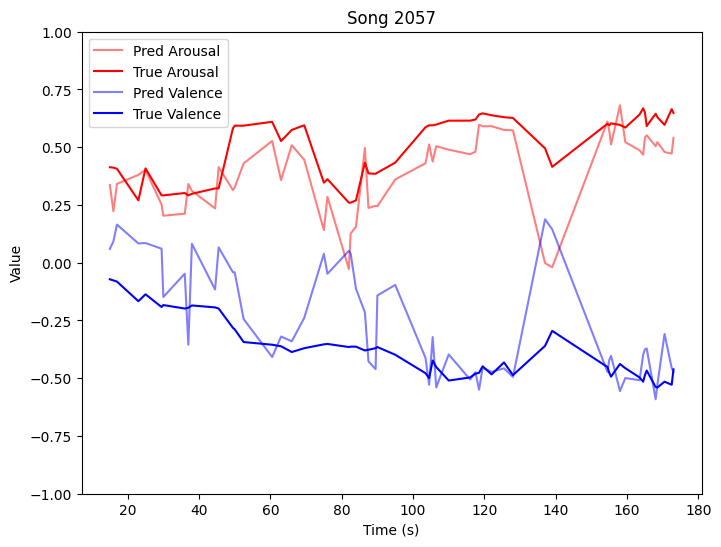

In [99]:
test_whole_song(2057)

## Data Insight

In [77]:
def find_top_30_extreme_songs(data):
    """
    data: DataFrame with columns at least:
      - song_id
      - arousal_value
      - valence_value

    Returns a DataFrame of the top 30 songs with the largest
    (max abs(arousal) + max abs(valence)) measure.
    """
    # 1) Group by song_id
    grouped = data.groupby('song_id')

    # 2) Compute max absolute arousal and valence for each song
    agg_df = grouped.agg(
        max_abs_arousal=('arousal_value', lambda x: x.abs().max()),
        max_abs_valence=('valence_value', lambda x: x.abs().max())
    ).reset_index()

    # 3) Create a combined measure
    agg_df['combined_extreme'] = agg_df['max_abs_arousal'] + agg_df['max_abs_valence']

    # 4) Sort descending by combined_extreme
    agg_df = agg_df.sort_values(by='combined_extreme', ascending=False)

    # 5) Pick the top 30
    top_30 = agg_df.head(30)

    return top_30

In [78]:
top_30_songs = find_top_30_extreme_songs(data)
print(top_30_songs)

      song_id  max_abs_arousal  max_abs_valence  combined_extreme
1744     2001         0.898000         0.748000          1.646000
1748     2005         0.792000         0.832000          1.624000
1776     2033         0.785000         0.768333          1.553333
1757     2014         0.788000         0.756000          1.544000
1141     1398         0.808000         0.588000          1.396000
1504     1761         0.657000         0.691000          1.348000
1745     2002         0.676000         0.668000          1.344000
89        115         0.727178         0.603395          1.330573
1112     1369         0.677000         0.652000          1.329000
1463     1720         0.590000         0.716000          1.306000
485       629         0.663342         0.635069          1.298411
1755     2012         0.618333         0.678333          1.296667
1082     1339         0.686000         0.606000          1.292000
1135     1392         0.678000         0.609000          1.287000
1110     1